In [1]:
using LinearAlgebra

In [2]:
struct Parm
    γg::Float64
    γl::Float64
    gt::Float64
    ω::Float64
    Nmax::Int
    rmax::Float64
end

In [38]:
p0 = Parm(0.5, 1.0, 0.01, 0.1, 10, 16.0)

Parm(0.5, 1.0, 0.01, 0.1, 10, 16.0)

In [59]:
p_test = Parm(0.5, 1.0, 0.01, 0.1, 2, 16.0)

Parm(0.5, 1.0, 0.01, 0.1, 2, 16.0)

In [53]:
function make_GKSL(p::Parm)
    GKSL = zeros(ComplexF64, (p.Nmax+1)^2, (p.Nmax+1)^2)
    #Diagonal part
    for i in 0:p.Nmax
        for j in 0:p.Nmax
            ##consider the term act on \rho[i,j]
            #Hermitian part
            GKSL[i*(p.Nmax+1)+j+1, i*(p.Nmax+1)+j+1] += -1.0im * (i-j) * p.ω

            #loss term
            if(i>0 && j>0)
                GKSL[(i-1)*(p.Nmax+1)+j, i*(p.Nmax+1)+j+1] += p.γl * sqrt(i*j)
                GKSL[i*(p.Nmax+1)+j+1, i*(p.Nmax+1)+j+1] -= (i+j) * p.γl / 2.0
            end
            #GKSL[i*(p.Nmax+1)+j+1, i*(p.Nmax+1)+j+1] -= (i+j) * p.γl / 2.0

            #gain term
            if(i<p.Nmax && j<p.Nmax)
                GKSL[(i+1)*(p.Nmax+1)+j+2, i*(p.Nmax+1)+j+1] += p.γg * sqrt((i+1)*(j+1))
                GKSL[i*(p.Nmax+1)+j+1, i*(p.Nmax+1)+j+1] -= (i+j+2) * p.γg / 2.0
            end
            #GKSL[i*(p.Nmax+1)+j+1, i*(p.Nmax+1)+j+1] -= (i+j+2) * p.γg / 2.0

            #interaction term
            if(i>1 && j>1)
                GKSL[(i-2)*(p.Nmax+1)+j-1, i*(p.Nmax+1)+j+1] += p.gt * sqrt(i*(i-1)*j*(j-1)) /2.0
            end
            if(i>1)
                GKSL[(i-2)*(p.Nmax+1)+j+1, i*(p.Nmax+1)+j+1] += p.gt * j *sqrt(i*(i-1)) /2.0 - p.gt * (i-2)*sqrt(i*(i-1)) /4.0
            end
            if(j>1)
                GKSL[i*(p.Nmax+1)+j-1, i*(p.Nmax+1)+j+1] += p.gt * i *sqrt(j*(j-1)) /2.0 - p.gt * (j-2)*sqrt(j*(j-1)) /4.0
            end

            if(i<p.Nmax-1)
                GKSL[(i+2)*(p.Nmax+1)+j+1, i*(p.Nmax+1)+j+1] -= p.gt * i *sqrt((i+2)*(i+1)) /4.0
            end
            if(j<p.Nmax-1)
                GKSL[i*(p.Nmax+1)+j+3, i*(p.Nmax+1)+j+1] -= p.gt * j *sqrt((j+2)*(j+1)) /4.0
            end
            GKSL[i*(p.Nmax+1)+j+1, i*(p.Nmax+1)+j+1] += i* j * p.gt / 2.0 - (2*i^2-i + 2*j^2-j) * p.gt / 4.0
        end
    end
    return GKSL
end

make_GKSL (generic function with 1 method)

In [60]:
test_L = make_GKSL(p_test)

9×9 Matrix{ComplexF64}:
 -0.5+0.0im       0.0+0.0im  …         0.0+0.0im       0.01+0.0im
  0.0+0.0im   -0.7525+0.1im     0.00707107+0.0im        0.0+0.0im
  0.0+0.0im       0.0+0.0im            0.0+0.0im  0.0141421+0.0im
  0.0+0.0im       0.0+0.0im        1.41421+0.0im        0.0+0.0im
  0.5+0.0im       0.0+0.0im            0.0+0.0im        2.0+0.0im
  0.0+0.0im  0.707107+0.0im  …         0.0+0.0im        0.0+0.0im
  0.0+0.0im       0.0+0.0im            0.0+0.0im  0.0141421+0.0im
  0.0+0.0im       0.0+0.0im        -1.5075-0.1im        0.0+0.0im
  0.0+0.0im       0.0+0.0im            0.0+0.0im      -2.01+0.0im

In [77]:
function check_conservation(GKSL)
    l = Int(sqrt(size(GKSL)[1]))
    for i in 0:l-1
        n = i*(l+1)+1
        s = 0.0
        for j in 0:l-1
            m = j*(l+1)+1
            s += GKSL[m,n]
        end
        println("$(i), $(n); sum:$(s)")
    end
end

function check_tr_positivity(rho_vec)
    l = Int(sqrt(size(rho_vec)[1]))
    rho = reshape(rho_vec, (l,l))
    println("trace:$(tr(rho))")
end

check_tr_positivity (generic function with 1 method)

In [63]:
test_L[:,9]

9-element Vector{ComplexF64}:
                 0.01 + 0.0im
                  0.0 + 0.0im
 0.014142135623730952 + 0.0im
                  0.0 + 0.0im
                  2.0 + 0.0im
                  0.0 + 0.0im
 0.014142135623730952 + 0.0im
                  0.0 + 0.0im
                -2.01 + 0.0im

In [78]:
check_conservation(test_L)

0, 1; sum:0.0 + 0.0im
1, 5; sum:0.0 + 0.0im
2, 9; sum:0.0 + 0.0im


In [72]:
rho_test = [0.3, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 0.2]

9-element Vector{Float64}:
 0.3
 1.0
 1.0
 1.0
 0.5
 1.0
 1.0
 1.0
 0.2

In [73]:
drho = exp(test_L) * rho_test

9-element Vector{ComplexF64}:
 0.48358735679403997 + 0.0im
  1.2194313427094523 + 0.12192686665758584im
  0.9682725021505012 + 0.19599718809578645im
  1.2194313427094525 - 0.12192686665758586im
  0.3322758720371279 + 0.0im
  0.6515601562565321 + 0.06529698208635068im
  0.9682725021505012 - 0.19599718809578645im
  0.6515601562565321 - 0.06529698208635068im
  0.1841367711688321 + 0.0im

In [74]:
check_tr_positivity(drho)

trace:0.9999999999999999 + 0.0im


In [112]:
p10 = Parm(0.5, 1.0, 0.01, 0.1, 10, 16.0)
L_n10 = make_GKSL(p10)
check_conservation(L_n10)

0, 1; sum:0.0 + 0.0im
1, 13; sum:0.0 + 0.0im
2, 25; sum:0.0 + 0.0im
3, 37; sum:-4.440892098500626e-16 + 0.0im
4, 49; sum:0.0 + 0.0im
5, 61; sum:0.0 + 0.0im
6, 73; sum:0.0 + 0.0im
7, 85; sum:-8.881784197001252e-16 + 0.0im
8, 97; sum:0.0 + 0.0im
9, 109; sum:0.0 + 0.0im
10, 121; sum:0.0 + 0.0im


In [82]:
using Plots

In [136]:
function get_Elog_vec(p::Parm, GKSL)
    e,v = eigen(GKSL)
    Elog = 1.0im*imag.(e) + log.(abs.(real.(e)) .+ 1.0e-14)
    if(length(Elog) > 100)
        Elog = Elog[end-99:end]
        v = v[end-99:end,:]
    end
    vec = []
    for i in 0:size(Elog)[1]-1
        if(real(Elog[end-i]) < -6)
            vv = reshape(v[end-i,:], (p.Nmax+1, p.Nmax+1))
            push!(vec, vv)
        else
            break
        end
    end
    return Elog, vec
end

get_Elog_vec (generic function with 2 methods)

In [137]:
E_log, SS_vec = get_Elog_vec(p10, L_n10)

(ComplexF64[2.575778606169449 - 0.6997191782013401im, 2.5757786061694463 + 0.6997191782013433im, 2.533429431016171 + 0.40116245584013416im, 2.5334294310161707 - 0.40116245584012067im, 2.5045561938922503 + 0.09793562826369419im, 2.504556193892246 - 0.09793562826369441im, 2.4205867811931214 - 0.5011529233542746im, 2.4205867811931205 + 0.5011529233542742im, 2.4095968998920583 - 0.20171633408055115im, 2.4095968998920565 + 0.20171633408054512im  …  -0.6164776618010811 - 2.581268532253489e-15im, -0.7902284589863019 + 0.9969493360497144im, -0.7902284589863059 - 0.996949336049707im, -0.8668285747632508 + 0.3008413421315415im, -0.8668285747632517 - 0.30084134213154357im, -1.5191329412773833 + 0.20034237803064806im, -1.5191329412773846 - 0.20034237803065116im, -2.7019789719846297 - 0.10007985121760017im, -2.7019789719846923 + 0.10007985121760404im, -31.932662306705833 - 2.9134715973429036e-16im], Any[ComplexF64[0.20773986142169898 - 2.3592239273284576e-16im 6.508653575375476e-16 - 6.279337789844

In [113]:
p20 = Parm(0.5, 1.0, 0.01, 0.1, 20, 16.0)
L_n20 = make_GKSL(p20)
check_conservation(L_n20)

0, 1; sum:0.0 + 0.0im
1, 23; sum:0.0 + 0.0im
2, 45; sum:0.0 + 0.0im
3, 67; sum:-4.440892098500626e-16 + 0.0im
4, 89; sum:0.0 + 0.0im
5, 111; sum:0.0 + 0.0im
6, 133; sum:0.0 + 0.0im
7, 155; sum:-8.881784197001252e-16 + 0.0im
8, 177; sum:0.0 + 0.0im
9, 199; sum:0.0 + 0.0im
10, 221; sum:0.0 + 0.0im
11, 243; sum:0.0 + 0.0im
12, 265; sum:0.0 + 0.0im
13, 287; sum:-1.7763568394002505e-15 + 0.0im
14, 309; sum:0.0 + 0.0im
15, 331; sum:0.0 + 0.0im
16, 353; sum:0.0 + 0.0im
17, 375; sum:0.0 + 0.0im
18, 397; sum:0.0 + 0.0im
19, 419; sum:0.0 + 0.0im
20, 441; sum:0.0 + 0.0im


In [138]:
E_log2, SS_vec2 = get_Elog_vec(p20, L_n20)

(ComplexF64[1.499852978105827 + 0.9130424169366655im, 1.481569575041717 + 0.38651727574478134im, 1.4815695750417035 - 0.386517275744743im, 1.4594955468288204 + 5.2146915611156734e-15im, 1.4343903015178012 + 0.6179103184832356im, 1.4343903015178008 - 0.617910318483276im, 1.4215020718743092 - 1.5437435669863337im, 1.4215020718743023 + 1.5437435669863158im, 1.4144523167467287 + 1.1108110881190065im, 1.4144523167467211 - 1.110811088119033im  …  -0.42568430400442214 + 0.4015524753924508im, -0.4256843040044359 - 0.4015524753924467im, -0.6323751909827132 - 3.2976970106316714e-15im, -0.8694582705017537 - 0.30078789129499517im, -0.869458270501828 + 0.30078789129499545im, -1.5210913971692244 + 0.2003191538482195im, -1.5210913971692541 - 0.2003191538482231im, -2.703275887869602 + 0.10007845730003287im, -2.7032758878698084 - 0.10007845730002538im, -30.571749325889083 - 2.9449748290498396e-15im], Any[ComplexF64[0.1352274653208412 + 6.938893903907228e-18im 1.5131898832741777e-7 + 1.0333476381624985e

In [ ]:
p20 = Parm(0.5, 1.0, 0.01, 0.1, 20, 16.0)
L_n20 = make_GKSL(p20)
check_conservation(L_n20)

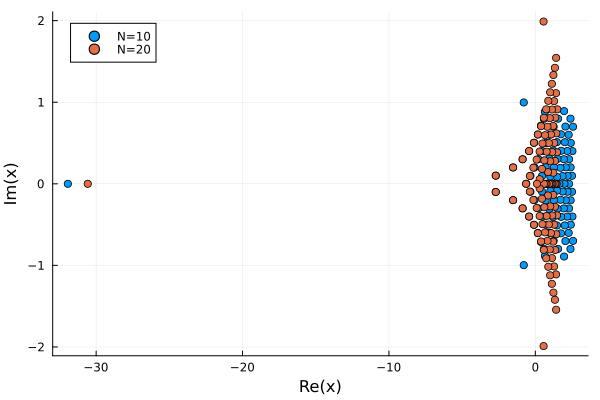

In [139]:
plot(E_log, st=:scatter, ps=0.5, xlabel="log(-Re(x))", label="N=10")
plot!(E_log2, st=:scatter, ps=0.5, label="N=20")

In [119]:
p10_LC = Parm(1.0, 0.5, 0.01, 0.1, 10, 16.0)
L_n10_LC = make_GKSL(p10_LC)
check_conservation(L_n10_LC)

0, 1; sum:0.0 + 0.0im
1, 13; sum:0.0 + 0.0im
2, 25; sum:0.0 + 0.0im
3, 37; sum:0.0 + 0.0im
4, 49; sum:0.0 + 0.0im
5, 61; sum:0.0 + 0.0im
6, 73; sum:0.0 + 0.0im
7, 85; sum:0.0 + 0.0im
8, 97; sum:0.0 + 0.0im
9, 109; sum:0.0 + 0.0im
10, 121; sum:0.0 + 0.0im


In [140]:
E_log_LC, SS_vec_LC = get_Elog_vec(p10_LC, L_n10_LC)

(ComplexF64[2.568923853577194 - 0.6993968202506111im, 2.5689238535771857 + 0.699396820250603im, 2.537442282949745 - 0.40121537198017815im, 2.5374422829497445 + 0.4012153719801777im, 2.5158026425594104 + 0.09688848806626763im, 2.5158026425594096 - 0.09688848806626403im, 2.4239479616045156 - 0.5011099621314697im, 2.4239479616045103 + 0.5011099621314642im, 2.4204380517696222 - 0.20183859800956588im, 2.420438051769621 + 0.20183859800958961im  …  -0.7574940708728577 - 1.0000147649940425im, -0.9134593414097079 - 0.4013712613033419im, -0.913459341409718 + 0.40137126130334067im, -1.4636280257799208 - 0.2987035711123394im, -1.4636280257799474 + 0.2987035711123391im, -2.1868079217022913 + 0.19670563255642884im, -2.1868079217023673 - 0.19670563255642973im, -2.9275313993074863 - 9.004648209403525e-15im, -5.480380148216608 + 1.1818893894270971e-14im, -31.15007111329329 + 2.0374824014674265e-15im], Any[ComplexF64[-0.4275668433250794 + 4.163336342344337e-17im -1.8184009926173296e-15 + 1.4198259035993

In [125]:
p20_LC = Parm(1.0, 0.5, 0.01, 0.1, 30, 16.0)
L_n20_LC = make_GKSL(p20_LC)
check_conservation(L_n20_LC)

0, 1; sum:0.0 + 0.0im
1, 33; sum:0.0 + 0.0im
2, 65; sum:0.0 + 0.0im
3, 97; sum:0.0 + 0.0im
4, 129; sum:0.0 + 0.0im
5, 161; sum:0.0 + 0.0im
6, 193; sum:0.0 + 0.0im
7, 225; sum:0.0 + 0.0im
8, 257; sum:0.0 + 0.0im
9, 289; sum:0.0 + 0.0im
10, 321; sum:0.0 + 0.0im
11, 353; sum:0.0 + 0.0im
12, 385; sum:0.0 + 0.0im
13, 417; sum:0.0 + 0.0im
14, 449; sum:0.0 + 0.0im
15, 481; sum:0.0 + 0.0im
16, 513; sum:0.0 + 0.0im
17, 545; sum:0.0 + 0.0im
18, 577; sum:0.0 + 0.0im
19, 609; sum:0.0 + 0.0im
20, 641; sum:0.0 + 0.0im
21, 673; sum:0.0 + 0.0im
22, 705; sum:0.0 + 0.0im
23, 737; sum:0.0 + 0.0im
24, 769; sum:0.0 + 0.0im
25, 801; sum:0.0 + 0.0im
26, 833; sum:0.0 + 0.0im
27, 865; sum:3.552713678800501e-15 + 0.0im
28, 897; sum:0.0 + 0.0im
29, 929; sum:0.0 + 0.0im
30, 961; sum:0.0 + 0.0im


In [141]:
E_log_LC2, SS_vec_LC2 = get_Elog_vec(p20_LC, L_n20_LC)

(ComplexF64[1.1971952380249986 + 4.625226727783473e-15im, 1.1494595891365698 + 0.7892154947881971im, 1.1494595891365273 - 0.7892154947880887im, 1.136839210289177 - 0.43002931525913873im, 1.136839210289117 + 0.43002931525934357im, 1.11847402259312 - 1.6334722270793218im, 1.1184740225930978 + 1.63347222707934im, 1.1145260275441837 + 1.0084101342246117im, 1.1145260275441815 - 1.0084101342246357im, 1.0674725063390995 - 0.6371836134989876im  …  -0.5612189069305452 + 8.021008952611542e-14im, -0.6549270584971172 - 7.85182235482405e-14im, -0.7538140740825405 - 2.1917319162267785e-14im, -0.7554974270245701 + 0.45721733499883227im, -0.7554974270247257 - 0.45721733499866574im, -1.2729391470046727 + 0.3082505955145067im, -1.2729391470047744 - 0.30825059551450534im, -1.9921594861397574 + 2.3796299023608484e-14im, -30.666294050502472 + 1.484786332213224e-14im, -1.481494465938259 - 9.034439862887211e-15im], Any[])

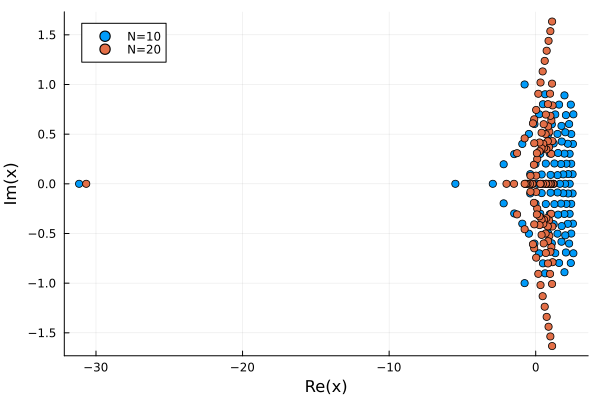

In [142]:
plot(E_log_LC, st=:scatter, ps=0.5, xlabel="log(-Re(x))", label="N=10")
plot!(E_log_LC2, st=:scatter, ps=0.5, label="N=20")

In [144]:
@show SS_vec_LC[1]

SS_vec_LC[1] = ComplexF64[-0.4275668433250794 + 4.163336342344337e-17im -1.8184009926173296e-15 + 1.419825903599394e-14im -2.3716954952129927e-15 + 1.457342613406361e-15im 0.6680177134862136 + 0.0im 3.7488200907241885e-15 - 6.3205708139381245e-15im -0.0006576682239335464 + 0.0003134972561576158im -4.535734959540535e-15 - 6.508589226241626e-15im 0.00018298154178037607 + 0.00015406833297398502im 8.910744658164748e-18 + 1.028542921777456e-15im -4.074726575594113e-16 + 2.0412745222374274e-15im 2.9094826047700976e-7 - 8.671132592473281e-7im; -3.157400970215432e-15 - 1.1628261522466221e-15im -2.048602787711003e-15 + 2.8999118452558653e-15im 0.00017458927406585611 + 0.000184998851573547im -8.511603283713145e-15 + 4.692682151855105e-15im -4.479872275529579e-18 - 3.908859142544073e-15im -0.0006576682239309909 - 0.00031349725614350515im 1.6546675208168339e-15 - 1.810486051546787e-15im 0.00018298154176266162 - 0.000154068332974851im 9.46056931291553e-16 - 1.1185181819242601e-15im 0.72290185916383

11×11 Matrix{ComplexF64}:
    -0.427567+4.16334e-17im  …    2.90948e-7-8.67113e-7im
  -3.1574e-15-1.16283e-15im       2.90948e-7+8.67113e-7im
 -1.67964e-15+1.13684e-15im      -0.00233156+0.00052983im
   -0.0459535+0.000963617im      -0.00233156-0.00052983im
   -0.0459535-0.000963617im     -1.05053e-15+3.16851e-17im
 -8.88818e-16-2.5762e-15im   …  -3.34424e-15-1.89305e-15im
 -1.30779e-15+2.31518e-15im       -0.0569858+0.00646141im
  -0.00177051+0.00703238im        -0.0569858-0.00646141im
  -0.00177051-0.00703238im       2.20398e-14-1.17044e-15im
    -0.549355+1.11022e-16im     -3.30525e-14-2.33157e-13im
 -2.20758e-15-6.78418e-15im  …      0.514704+0.0im

In [111]:
tr(SS_vec[1]

0.17613380343319282 - 0.0021005076517529985im